In [2]:
import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

Set Some Parameters

In [ ]:
#Dataset information

#Test dataset is set explicitly, because the amount of data is very small
train_aug_image_folder = os.path.join ('datasets', 'face_dataset_train_aug_images')
train_image_folder = os.path.join('datasets', 'face_dataset_train_images')
test_image_folder = os.path.join('datasets', 'face_dataset_test_images')
img_height, img_width= 250,250 #size of images
num_classes = 2 #number of classes

#training settings
validation_ratio = 0.15 #15% for the validation
batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

Create Dataset

Read datasetrs from folders

In [5]:
#Train and validation sets of initial dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height,img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True   
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

Found 433 files belonging to 2 classes.
Using 369 files for training.
Found 433 files belonging to 2 classes.
Using 64 files for validation.


In [6]:
#train and validation sets of augmented dataset
train_aug_ds = keras.preprocessing.image_dataset_from_directory(
    train_aug_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height,img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)
val_aug_ds = keras.preprocessing.image_dataset_from_directory(
    train_aug_image_folder,
    validation_split=validation_ratio,
    subset='validation',
    seed=42,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

Found 695 files belonging to 2 classes.
Using 591 files for training.
Found 695 files belonging to 2 classes.
Using 104 files for validation.


In [7]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_image_folder,
    image_size=(img_height,img_width),
    label_mode='categorical',
    shuffle=False
)

Found 339 files belonging to 2 classes.


In [8]:
class_names = test_ds.class_names
class_names

['me', 'not_me']

Buld The Model

In [11]:
# Here I experiment with different models
# Each model is represented in it own cells

VGG16

In [7]:
base_model = keras.applications.vgg16.VGG16(weights='imagenet',
                                            include_top=False, #without dense part of the network
                                            input_shape=(img_height,img_width, 3))

#set Layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
#add custom layers on top of the convolutional layers of VGG16
flatten = keras.layers.Flatten()(base_model.output)
dense_4096_1 = keras.layers.Dense(4096, activation='relu')(flatten)
dense_4096_2 = keras.layers.Dense(4096, activation='relu')(dense_4096_1)
output = keras.layers.Dense(num_classes, activation = 'sigmoid')(dense_4096_2)

VGG16 = keras.models.Model(inputs = base_model.input, outputs= output, name = 'VGG16')
VGG16.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

ResNet50

In [9]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                          include_top = False, #without dense part of the network
                                          input_shape=(img_height, img_width, 3))

#set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

#add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation = 'sigmoid')(global_avg_pooling)

ResNet50 = keras.models.Model(inputs = base_model.input, outputs= output, name = 'ResNet50')

ResNet50.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

ResNet152

In [13]:
base_model = keras.applications.ResNet152(weights = 'imagenet',
                                          include_top= False, #without dense part of the network
                                          input_shape=(img_height,img_width,3))

#set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

#add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

ResNet152 = keras.models.Model(inputs = base_model.input,
                               outputs = output,
                               name = 'ResNet152')

ResNet152.summary()

234698864/234698864 [==============================] - 59s 0us/step
Model: "ResNet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                      

Xception

In [29]:
base_model = keras.applications.Xception(weights = 'imagenet',
                                          include_top= False, #without dense part of the network
                                          input_shape=(img_height,img_width,3))
#set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

#add custom layers on top of Xception
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output= keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

Xception= keras.models.Model(inputs = base_model.input,
                             outputs= output,
                             name= 'Xception')

Xception.summary()

83683744/83683744 [==============================] - 201s 2us/step
Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                 

MobileNet

In [44]:
base_model = keras.applications.MobileNet(weights = 'imagenet',
                                          include_top= False, #without dense part of the network
                                          input_shape=(img_height,img_width,3))

#set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
#add custom layers on top of MobileNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

MobileNet = keras.models.Model(inputs = base_model.input,
                               outputs=output,
                               name='MobileNet')

MobileNet.summary()

17225924/17225924 [==============================] - 4s 0us/step
Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 125, 125, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 125, 125, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 125, 125, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 125, 125, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 125, 125, 32)     128

Training

use one of the models

then choose if want to train CNN on augmented dataset

train_on_aug = True/False

In [10]:
face_classifier = ResNet50
face_classifier.summary() # to check that the model is chosen correctly

train_on_aug = False #train on augmented dataset

if train_on_aug:
    train_ds = train_aug_ds
    val_ds = val_aug_ds

if train_on_aug:
    name_to_save = f"models/face_classifier_{face_classifier.name}_aug.h5"
else:
    name_to_save = f"models/face_classifier_{face_classifier.name}.h5"

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

All models train in one context, so this part of the code is the same

In [11]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint(name_to_save,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=5,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [12]:
face_classifier.compile(loss='categorical_crossentropy',
                        optimizer = keras.optimizers.Adam(learning_rate=0.01),
                        metrics =['accuracy'])

In [13]:
epochs = 50

In [14]:
history = face_classifier.fit(
    train_ds,
    epochs = epochs,
    callbacks=callbacks,
    validation_data=val_ds)

face_classifier.save(name_to_save)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9892
Epoch 1: val_loss improved from inf to 0.00008, saving model to models\face_classifier_ResNet50.h5
24/24 [==============================] - 13s 164ms/step - loss: 0.0267 - accuracy: 0.9892 - val_loss: 8.3483e-05 - val_accuracy: 1.0000
Epoch 2/50
23/24 [===========================>..] - ETA: 0s - loss: 1.0448e-05 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.00008 to 0.00005, saving model to models\face_classifier_ResNet50.h5
24/24 [==============================] - 2s 81ms/step - loss: 1.0419e-05 - accuracy: 1.0000 - val_loss: 4.9204e-05 - val_accuracy: 1.0000
Epoch 3/50
23/24 [===========================>..] - ETA: 0s - loss: 6.6033e-06 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00005
24/24 [==============================] - 1s 52ms/step - loss: 6.5854e-06 - accuracy: 1.0000 - val_loss: 6.1337e-05 - val_accuracy: 1.0000
Epoch 4/50
24/24 [==============================]

Testing

In [16]:
model_name = 'face_classifier_ResNet50.h5'
face_classifier = keras.models.load_model(f'models/{model_name}')

In [17]:
def test_image_classifier_with_folder(model, path, y_true, img_height = 250, img_width = 250, class_names=['me', 'not me']):
    '''
    Read all images from 'path' using tensorflow.keras.preprocessing.image module,
    then classifies them using 'model' and compare result with 'y_true'.
    Calculate total accuracy based on 'path' test set
    
    parameters:
    model: Image classifier
    path(str): Path to the folder with images you want to test classifier on
    y_true: True label of the images in the folder. Must be in 'class_names' list
    img_height (int): The height of the image that the classifier can process
    img_width (int): The width of the image that the classifier can process
    class_names (array-like): List of class names
    
    Returns:
        None
    '''
    
    num_classes = len(class_names) # number of classes
    total = 0 # number of images total
    correct = 0 # number of images classified correctly
    
    for filename in os.listdir(path):
        #read each image in the folder and classifies it
        test_path = os.path.join(path,filename)
        test_image = keras.preprocessing.image.load_img( test_path, target_size=(img_height, img_width, 3))
        #from image to array, can try type (test_image)
        test_image = keras.preprocessing.image.img_to_array(test_image)
        #shape from (250,250,3) to (1,250,250,3)
        test_image = np.expand_dims(test_image, axis = 0)
        result = model.predict(test_image)
        
        y_pred = class_names[np.array(result[0]).argmax(axis=0)] # predicted class
        iscorrect = 'correct' if y_pred == y_true else 'incorrect'
        print('{} - {}'.format(iscorrect, filename))
        for index in range(num_classes):
            print("\t{:6} with probability of {:.2f}%".format(class_names[index], result[0][index]*100))
            
        total += 1
        if y_pred == y_true:
            correct +=1
        print("\n total accuracy is {:.2f}% = {}/{} samples classified correctly".format(correct/total*100, correct, total))

In [18]:
test_image_classifier_with_folder(face_classifier,'datasets/face_dataset_test_images/me', y_true = 'me')

1/1 [==============================] - 1s 958ms/step
correct - IMG_9208.JPG
	me     with probability of 99.89%
	not me with probability of 0.04%

 total accuracy is 100.00% = 1/1 samples classified correctly
1/1 [==============================] - 0s 55ms/step
correct - IMG_9209.JPG
	me     with probability of 99.89%
	not me with probability of 0.03%

 total accuracy is 100.00% = 2/2 samples classified correctly
1/1 [==============================] - 0s 22ms/step
correct - IMG_9210.JPG
	me     with probability of 99.92%
	not me with probability of 0.02%

 total accuracy is 100.00% = 3/3 samples classified correctly
1/1 [==============================] - 0s 22ms/step
correct - IMG_9211.JPG
	me     with probability of 99.99%
	not me with probability of 0.00%

 total accuracy is 100.00% = 4/4 samples classified correctly
1/1 [==============================] - 0s 22ms/step
correct - IMG_9212.JPG
	me     with probability of 92.72%
	not me with probability of 4.33%

 total accuracy is 100.00%

In [19]:
test_image_classifier_with_folder(face_classifier,'datasets/face_dataset_test_images/not_me', y_true = 'not_me')

1/1 [==============================] - 0s 22ms/step
incorrect - Aaron_Peirsol_0001.jpg
	me     with probability of 0.00%
	not me with probability of 100.00%

 total accuracy is 0.00% = 0/1 samples classified correctly
1/1 [==============================] - 0s 36ms/step
incorrect - Aaron_Peirsol_0002.jpg
	me     with probability of 0.00%
	not me with probability of 100.00%

 total accuracy is 0.00% = 0/2 samples classified correctly
1/1 [==============================] - 0s 23ms/step
incorrect - Aaron_Peirsol_0003.jpg
	me     with probability of 0.00%
	not me with probability of 100.00%

 total accuracy is 0.00% = 0/3 samples classified correctly
1/1 [==============================] - 0s 26ms/step
incorrect - Aaron_Peirsol_0004.jpg
	me     with probability of 0.00%
	not me with probability of 100.00%

 total accuracy is 0.00% = 0/4 samples classified correctly
1/1 [==============================] - 0s 20ms/step
incorrect - Abdel_Madi_Shabneh_0001.jpg
	me     with probability of 0.00%
	n

Test of particular image 

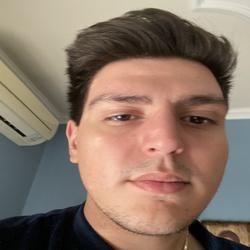

In [20]:
test_path = 'datasets/face_dataset_test_images/me/IMG_9208.jpg'
test_image = keras.preprocessing.image.load_img(test_path, target_size=(img_height,img_width,3))
test_image

In [21]:
test_image = keras.preprocessing.image.img_to_array(test_image) #from image to array
#shape from (250,250,3) to (1,250,250,3)
test_image = np.expand_dims(test_image, axis =0)
result = face_classifier.predict(test_image)

for index in range(num_classes):
    print("{:6} with propability of {:.2f}%".format(class_names[index], result[0][index] * 100))

1/1 [==============================] - 0s 29ms/step
me     with propability of 99.89%
not_me with propability of 0.04%


Plotting

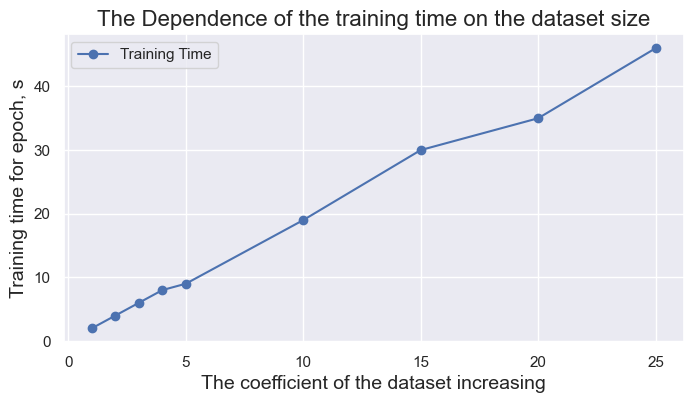

In [22]:
import matplotlib.pyplot as plt
dataset_size = [1, 2, 3, 4, 5, 10, 15, 20, 25]
training_time_per_epoch = [2, 4, 6, 8, 9, 19, 30, 35, 46]

fig=plt.figure(figsize=(8,4))
plt.plot(dataset_size, training_time_per_epoch, marker='o', label="Training Time")

plt.title("The Dependence of the training time on the dataset size", fontsize= '16')
plt.xlabel("The coefficient of the dataset increasing", fontsize = '14')
plt.ylabel("Training time for epoch, s", fontsize ='14')
plt.legend(loc='best')
plt.savefig('article/img/dataset_size_to_learning_time.jpg')
plt.show()

#the dependence of the training time (per epoch) on the dataset size is linear

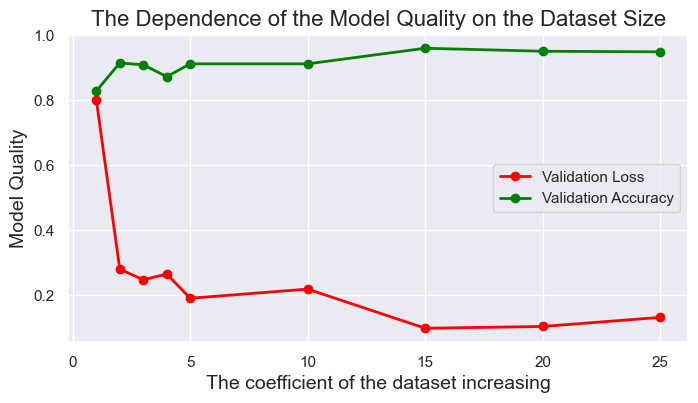

In [23]:
dataset_size=[1, 2, 3, 4, 5, 10, 15, 20, 25]
val_loss=[0.8011, 0.2802, 0.2479, 0.2653, 0.191, 0.2191, 0.09886, 0.10429, 0.1322]
val_accuracy = [0.8276, 0.9138, 0.908, 0.8718, 0.911, 0.911, 0.9589, 0.9497, 0.9479]


fig = plt.figure(figsize=(8, 4))
plt.plot(dataset_size, val_loss, c="red", linewidth=2, marker='o', label="Validation Loss")
plt.plot(dataset_size, val_accuracy, c="green", linewidth=2, marker='o', label="Validation Accuracy")

plt.title("The Dependence of the Model Quality on the Dataset Size", fontsize='16')
plt.xlabel("The coefficient of the dataset increasing", fontsize='14')
plt.ylabel("Model Quality", fontsize='14')
plt.legend(loc='best')
plt.savefig('article/img/dataset_size_to_model_quality.jpg')
plt.show()

